# Particle Analysis - Results Visualization

This notebook analyzes and visualizes particle size distributions from multiple SEM image datasets.
It generates publication-quality histograms and probability density functions for research papers.

## 1. Setup and Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import glob
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

# Set publication-quality matplotlib parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 5
rcParams['figure.dpi'] = 150
rcParams['savefig.dpi'] = 300
rcParams['savefig.bbox'] = 'tight'

# Set seaborn style for beautiful plots
sns.set_style('white')
sns.set_context('paper', font_scale=1.3)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration - Set Your Data Folder

In [50]:
# ============================================================================
# CONFIGURE THIS SECTION
# ============================================================================

# Path to folder containing your CSV files
RESULTS_FOLDER = "/Users/sanjaypradeep/Downloads/LA Fire Results"  # CHANGE THIS

# Pattern to match CSV files (e.g., "analysis_results_*.csv")
CSV_PATTERN = "analysis_results*.csv"

# Labels for each dataset (will be extracted from filenames if None)
# Example: {"analysis_results_A.csv": "TDS", "analysis_results_B.csv": "Open-Face"}
CUSTOM_LABELS = None  # Set to None to auto-generate labels

# Maximum cutoff diameter for plots (in micrometers)
MAX_DIAMETER_CUTOFF_UM = 10.0  # Particles larger than this will be excluded from plots

# Submicron cutoff for zoomed inset (in micrometers)
SUBMICRON_CUTOFF_UM = 1.0  # For the zoomed-in histogram inset

# Color for histograms (matplotlib color or hex code)
HISTOGRAM_COLOR = '#4A90E2'  # Blue color

# Output folder for saved figures
OUTPUT_FOLDER = "./figures"

# ============================================================================

## 3. Load and Parse Results Files

In [51]:
def parse_list_string(s):
    """
    Parse string representation of list back to actual list.
    Handles both string lists and empty lists.
    """
    if pd.isna(s) or s == '[]' or s == '':
        return []
    try:
        return eval(s)
    except:
        return []


def load_results(csv_path):
    """
    Load a single results CSV file and extract particle measurements.
    
    Returns:
        dict: Dictionary with 'diameters' list in nm units
    """
    df = pd.read_csv(csv_path)
    
    all_diameters = []
    
    for idx, row in df.iterrows():
        # Parse nm measurements
        diams_nm = parse_list_string(row['equiv_diameters_nm'])
        all_diameters.extend(diams_nm)
    
    return {
        'diameters': np.array(all_diameters),
        'num_particles': len(all_diameters),
        'num_images': len(df)
    }


def load_all_results(folder, pattern):
    """
    Load all CSV files matching the pattern from the specified folder.
    
    Returns:
        dict: Dictionary mapping dataset labels to measurement data
    """
    folder_path = Path(folder)
    csv_files = sorted(folder_path.glob(pattern))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found matching '{pattern}' in {folder}")
    
    results = {}
    
    for csv_file in csv_files:
        # Generate label from filename
        if CUSTOM_LABELS and csv_file.name in CUSTOM_LABELS:
            label = CUSTOM_LABELS[csv_file.name]
        else:
            # Extract label from filename (e.g., "analysis_results_A.csv" -> "A")
            label = csv_file.stem.replace('analysis_results_', '').replace('analysis_results', 'Dataset')
            if not label:
                label = csv_file.stem
        
        print(f"Loading {csv_file.name} as '{label}'...")
        results[label] = load_results(csv_file)
        print(f"  → {results[label]['num_particles']} particles from {results[label]['num_images']} images")
    
    return results


# Load all results
datasets = load_all_results(RESULTS_FOLDER, CSV_PATTERN)
print(f"\n✓ Loaded {len(datasets)} datasets successfully")

Loading analysis_results A.csv as 'Dataset A'...
  → 602 particles from 8 images
Loading analysis_results B.csv as 'Dataset B'...
  → 740 particles from 11 images
Loading analysis_results D.csv as 'Dataset D'...
  → 729 particles from 6 images
Loading analysis_results E.csv as 'Dataset E'...
  → 163 particles from 7 images
Loading analysis_results F.csv as 'Dataset F'...
  → 480 particles from 11 images
Loading analysis_results G.csv as 'Dataset G'...
  → 95 particles from 15 images
Loading analysis_results H.csv as 'Dataset H'...
  → 424 particles from 9 images
Loading analysis_results I.csv as 'Dataset I'...
  → 585 particles from 8 images
Loading analysis_results J.csv as 'Dataset J'...
  → 195 particles from 18 images
Loading analysis_results K.csv as 'Dataset K'...
  → 64 particles from 10 images

✓ Loaded 10 datasets successfully


## 4. Summary Statistics with Advanced Metrics

In [52]:
def calculate_statistics(data):
    """
    Calculate comprehensive statistics for a dataset.
    """
    diameters = data['diameters']
    
    if len(diameters) == 0:
        return None
    
    # Count particles under specific thresholds
    under_1um = np.sum(diameters < 1000)  # Convert 1um to nm
    under_200nm = np.sum(diameters < 200)
    
    return {
        'Count': len(diameters),
        'Images': data['num_images'],
        'Mean (nm)': np.mean(diameters),
        'Median (nm)': np.median(diameters),
        'Std (nm)': np.std(diameters),
        'Min (nm)': np.min(diameters),
        'Max (nm)': np.max(diameters),
        'Under 1μm': under_1um,
        'Under 200nm': under_200nm
    }


# Create summary table
summary_data = {}
for label, data in datasets.items():
    summary_data[label] = calculate_statistics(data)

summary_df = pd.DataFrame(summary_data).T

# Format numerical columns
for col in ['Mean (nm)', 'Median (nm)', 'Std (nm)', 'Min (nm)', 'Max (nm)']:
    summary_df[col] = summary_df[col].round(3)

# Convert count columns to integers
for col in ['Count', 'Images', 'Under 1μm', 'Under 200nm']:
    summary_df[col] = summary_df[col].astype(int)

print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
print(summary_df.to_string())
print("="*100)


SUMMARY STATISTICS
           Count  Images  Mean (nm)  Median (nm)   Std (nm)  Min (nm)    Max (nm)  Under 1μm  Under 200nm
Dataset A    602       8   2813.790     1964.744   3133.534    84.954   38022.281        125            6
Dataset B    740      11   3208.677     2348.847   3166.650    39.055   34101.152        142           15
Dataset D    729       6    980.945      628.156   1611.184    27.277   27728.726        544           77
Dataset E    163       7   1791.539      787.035   2631.720    53.173   15818.865         93           15
Dataset F    480      11   4477.177     3731.314   4626.642    37.599   66228.629         70           49
Dataset G     95      15   5732.889     4173.060   8662.850   284.790   64004.520          8            0
Dataset H    424       9   4863.638     3948.745   3495.478   136.488   25351.395         12            1
Dataset I    585       8   3440.942     2671.454   3135.657    54.554   27987.167         56           16
Dataset J    195      18  

## 5. Create Summary Statistics Table Image

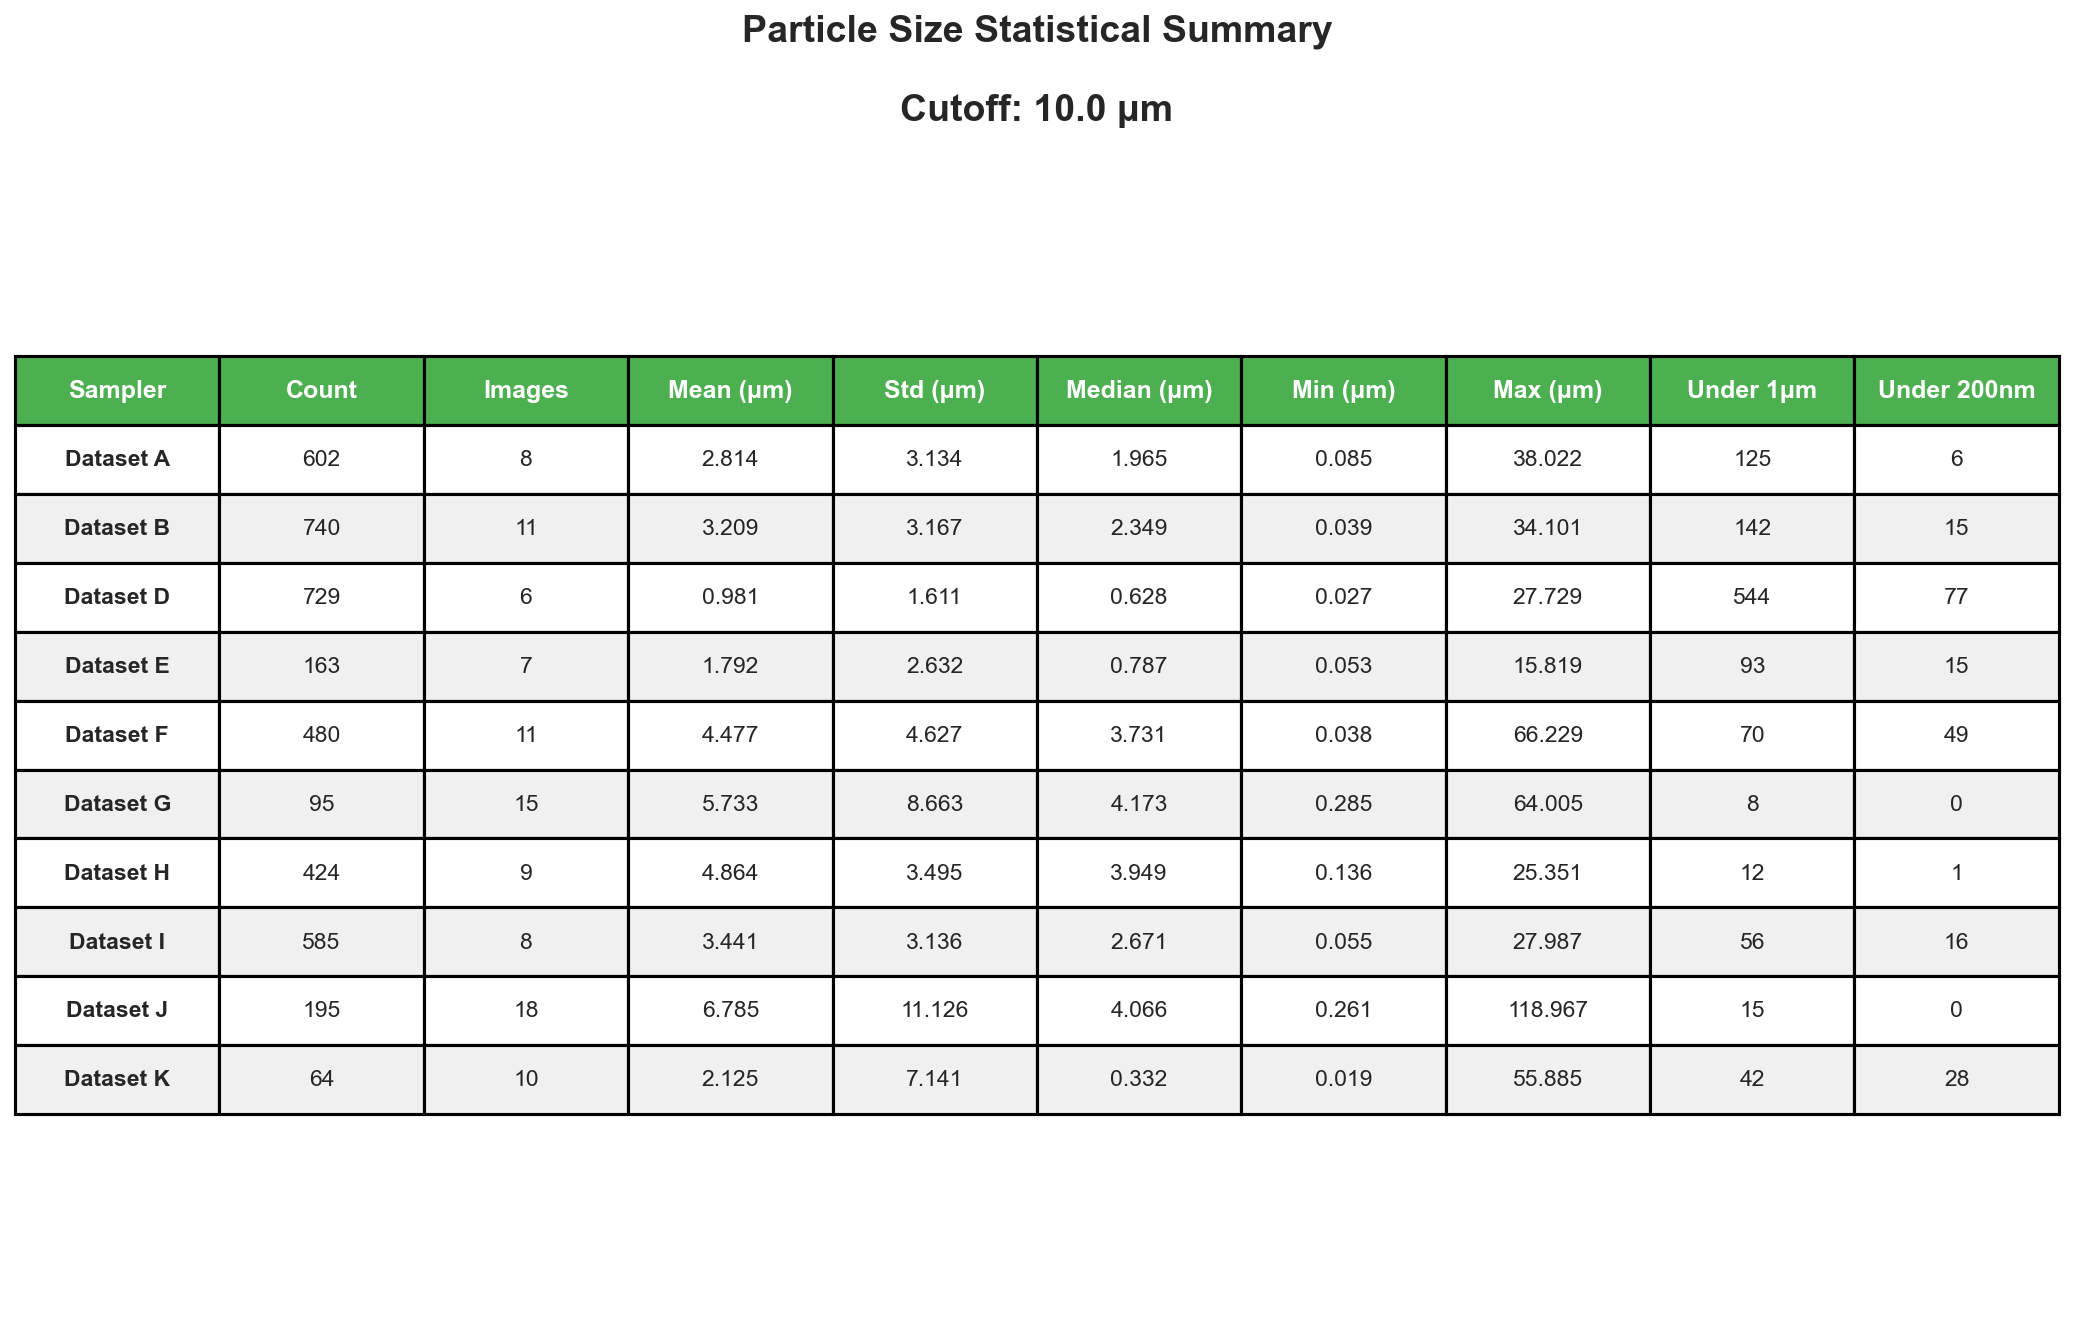

In [53]:
def create_summary_table_image(summary_df, cutoff_um):
    """
    Create a publication-quality summary table as an image.
    """
    fig, ax = plt.subplots(figsize=(14, 4 + 0.5 * len(summary_df)))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = []
    headers = ['Sampler', 'Count', 'Images', 'Mean (μm)', 'Std (μm)', 'Median (μm)', 
               'Min (μm)', 'Max (μm)', 'Under 1μm', 'Under 200nm']
    
    for idx, row in summary_df.iterrows():
        table_row = [
            idx,  # Sampler name
            int(row['Count']),
            int(row['Images']),
            f"{row['Mean (nm)']/1000:.3f}",  # Convert to μm
            f"{row['Std (nm)']/1000:.3f}",   # Convert to μm
            f"{row['Median (nm)']/1000:.3f}",# Convert to μm
            f"{row['Min (nm)']/1000:.3f}",   # Convert to μm
            f"{row['Max (nm)']/1000:.3f}",   # Convert to μm
            int(row['Under 1μm']),
            int(row['Under 200nm'])
        ]
        table_data.append(table_row)
    
    # Create table
    table = ax.table(cellText=table_data, colLabels=headers, 
                     cellLoc='center', loc='center',
                     colColours=['#4CAF50'] * len(headers))
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Bold header text and set white color
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_text_props(weight='bold', color='white', fontsize=12)
            cell.set_facecolor('#4CAF50')
        else:
            # Alternate row colors
            if i % 2 == 0:
                cell.set_facecolor('#F0F0F0')
            else:
                cell.set_facecolor('white')
            
            # Make first column (sampler name) bold
            if j == 0:
                cell.set_text_props(weight='bold')
        
        # Add borders
        cell.set_edgecolor('black')
        cell.set_linewidth(1.5)
    
    # Add title
    title_text = f'Particle Size Statistical Summary\n\nCutoff: {cutoff_um} μm'
    plt.title(title_text, fontsize=18, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# Create summary table image
fig_summary_table = create_summary_table_image(summary_df, MAX_DIAMETER_CUTOFF_UM)
plt.show()

## 6. Individual Histograms with Submicron Inset


Creating histogram for Dataset A...


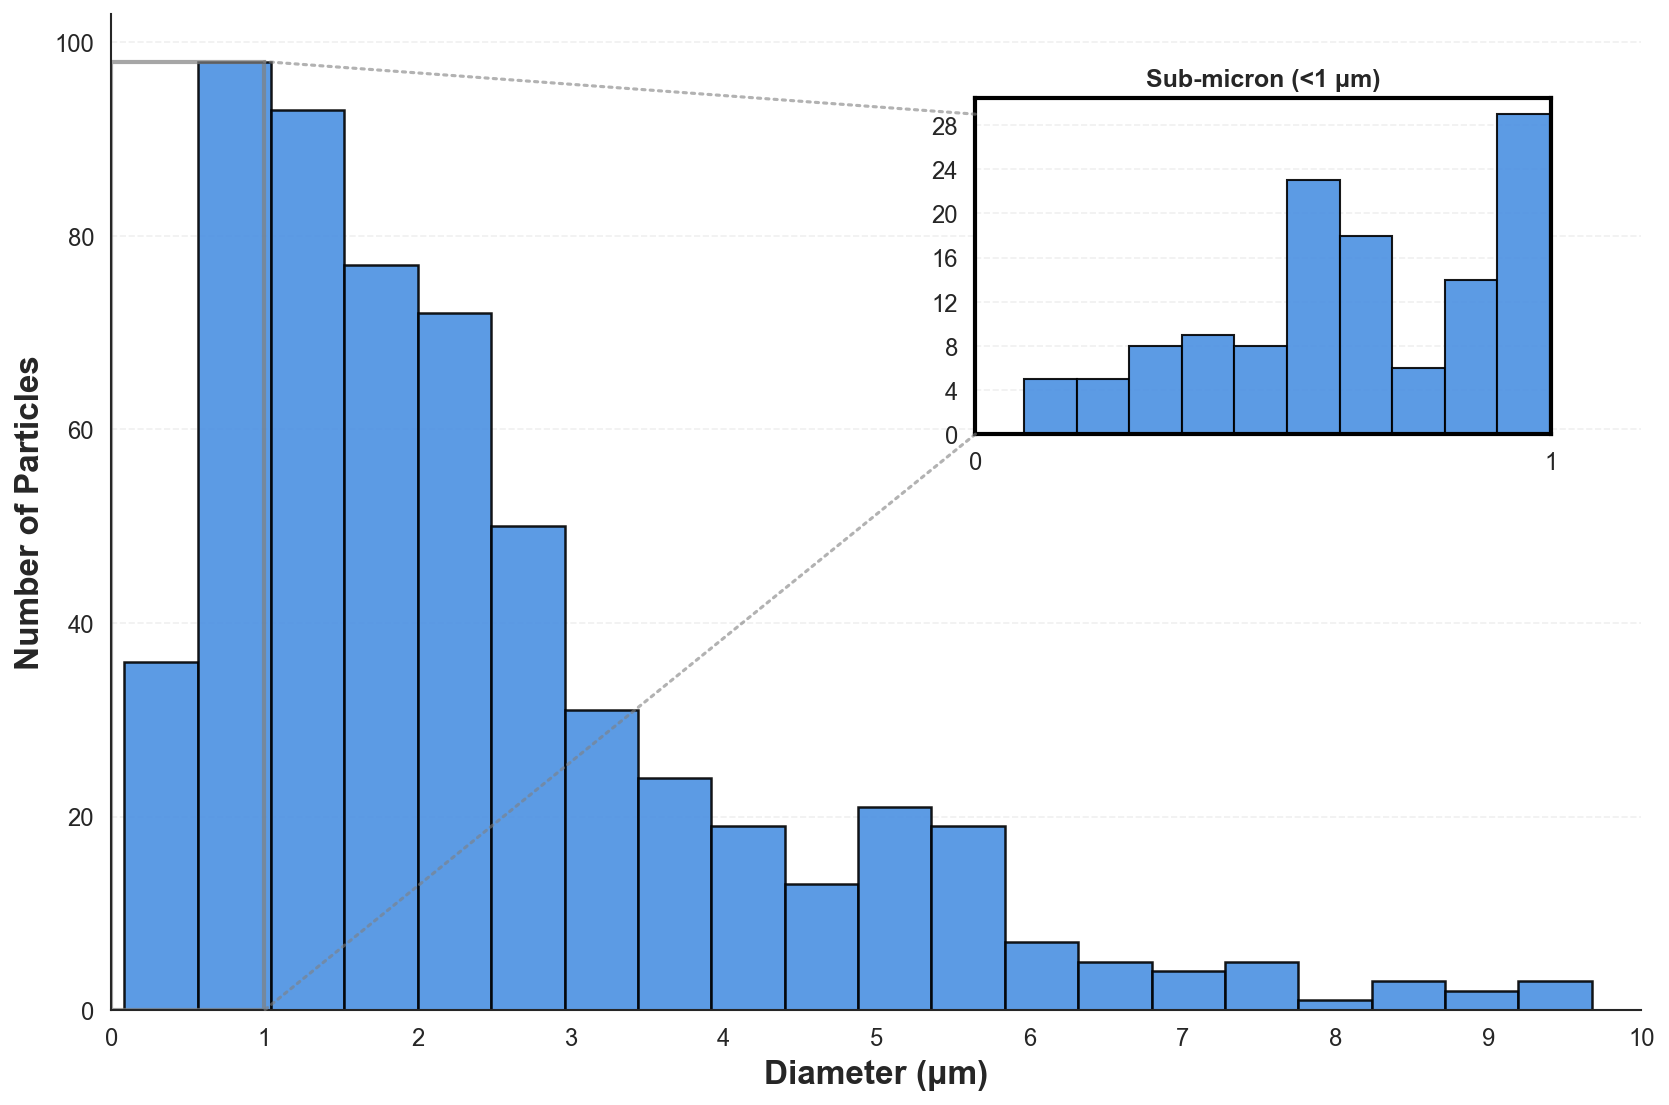


Creating histogram for Dataset B...


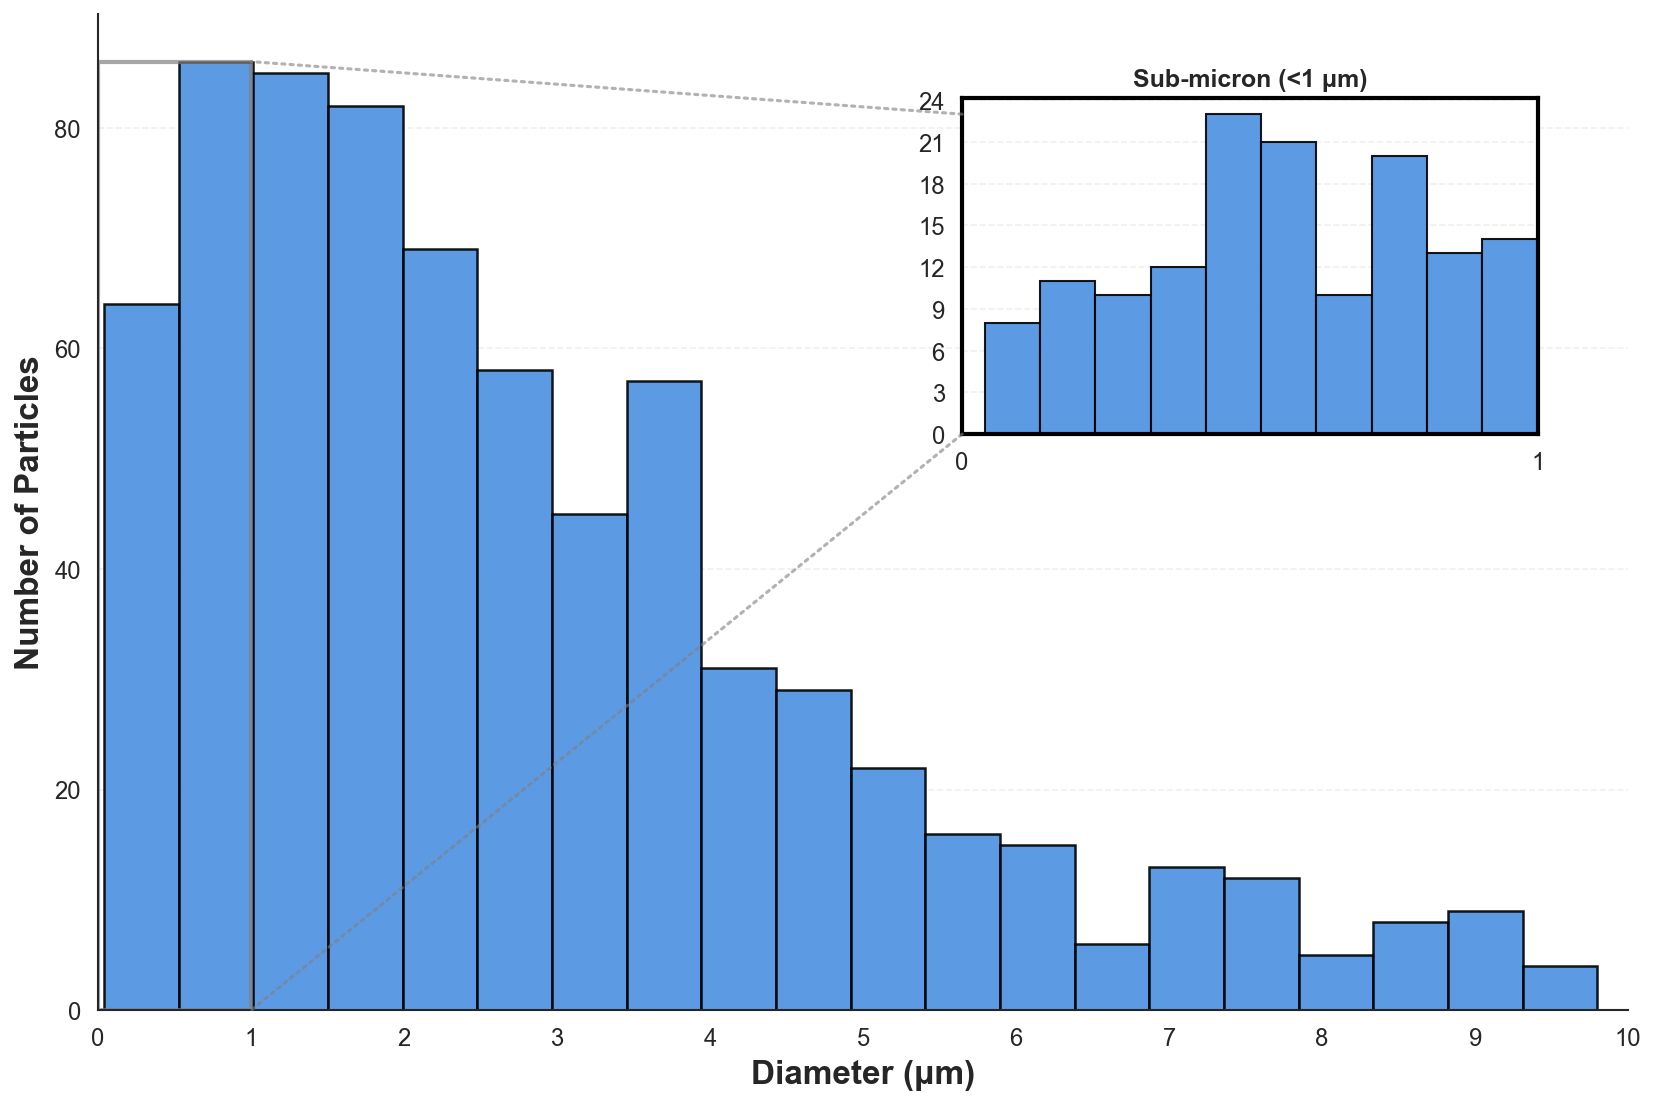


Creating histogram for Dataset D...


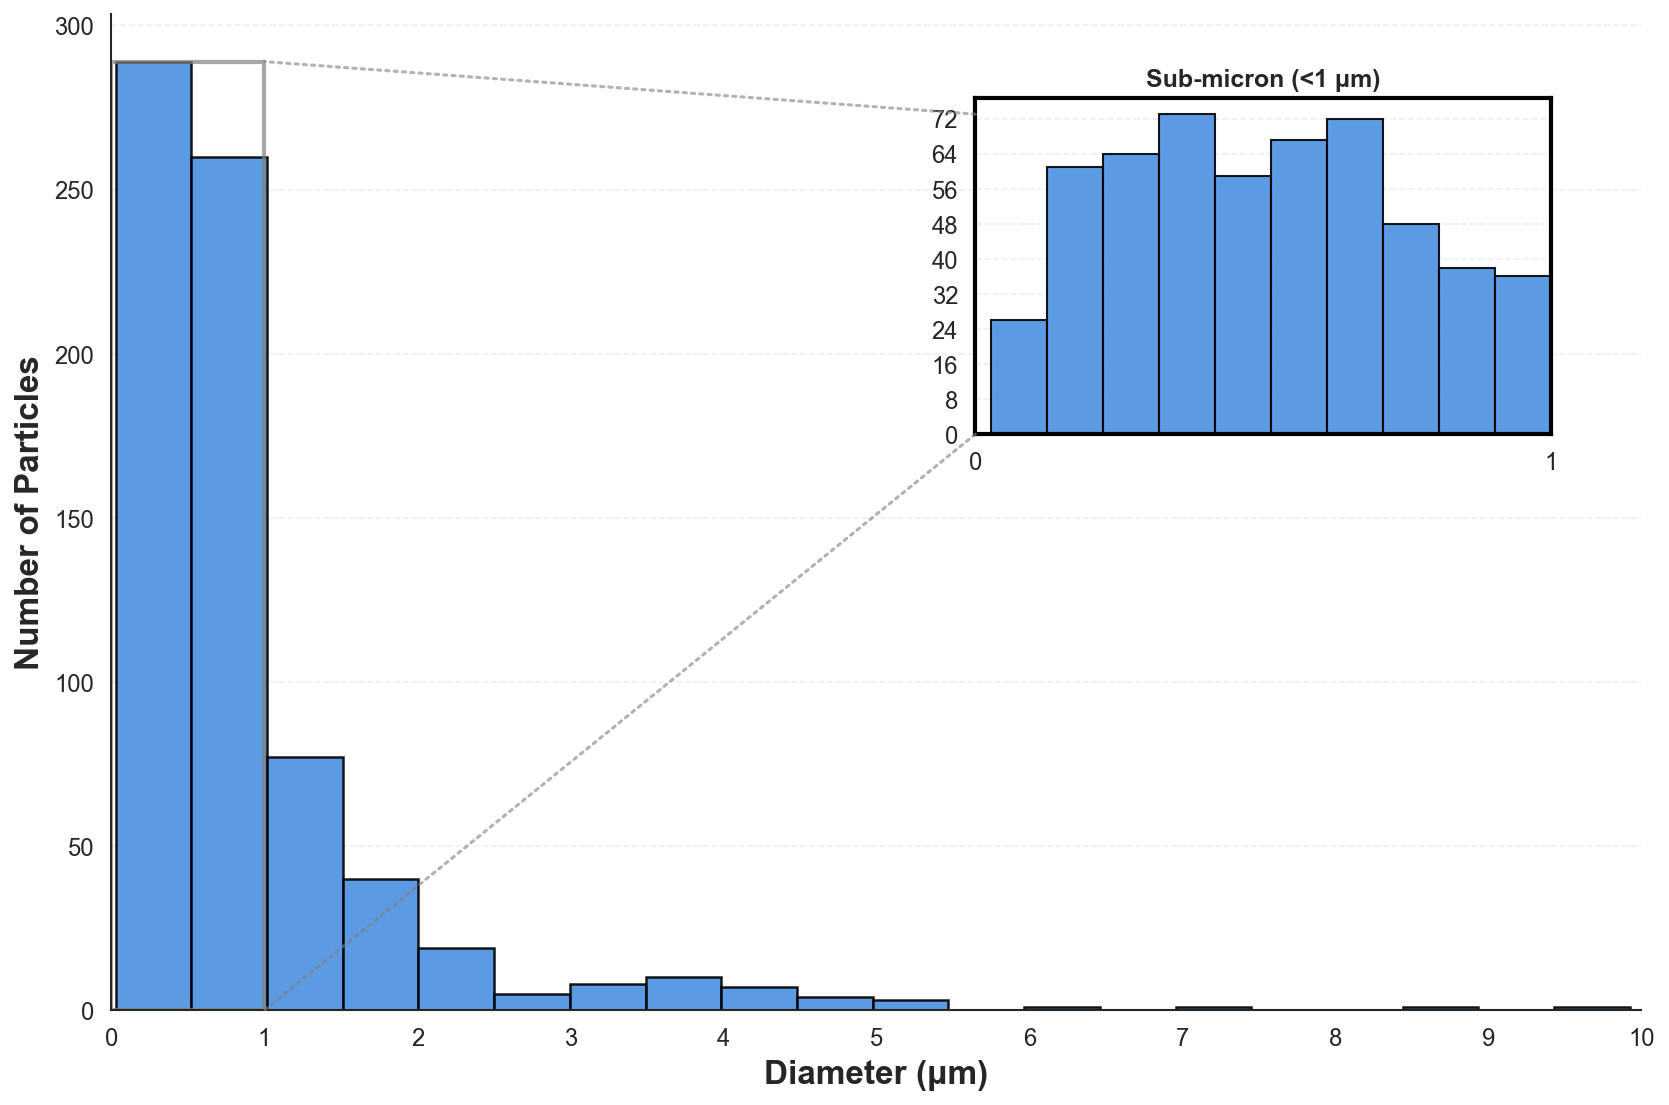


Creating histogram for Dataset E...


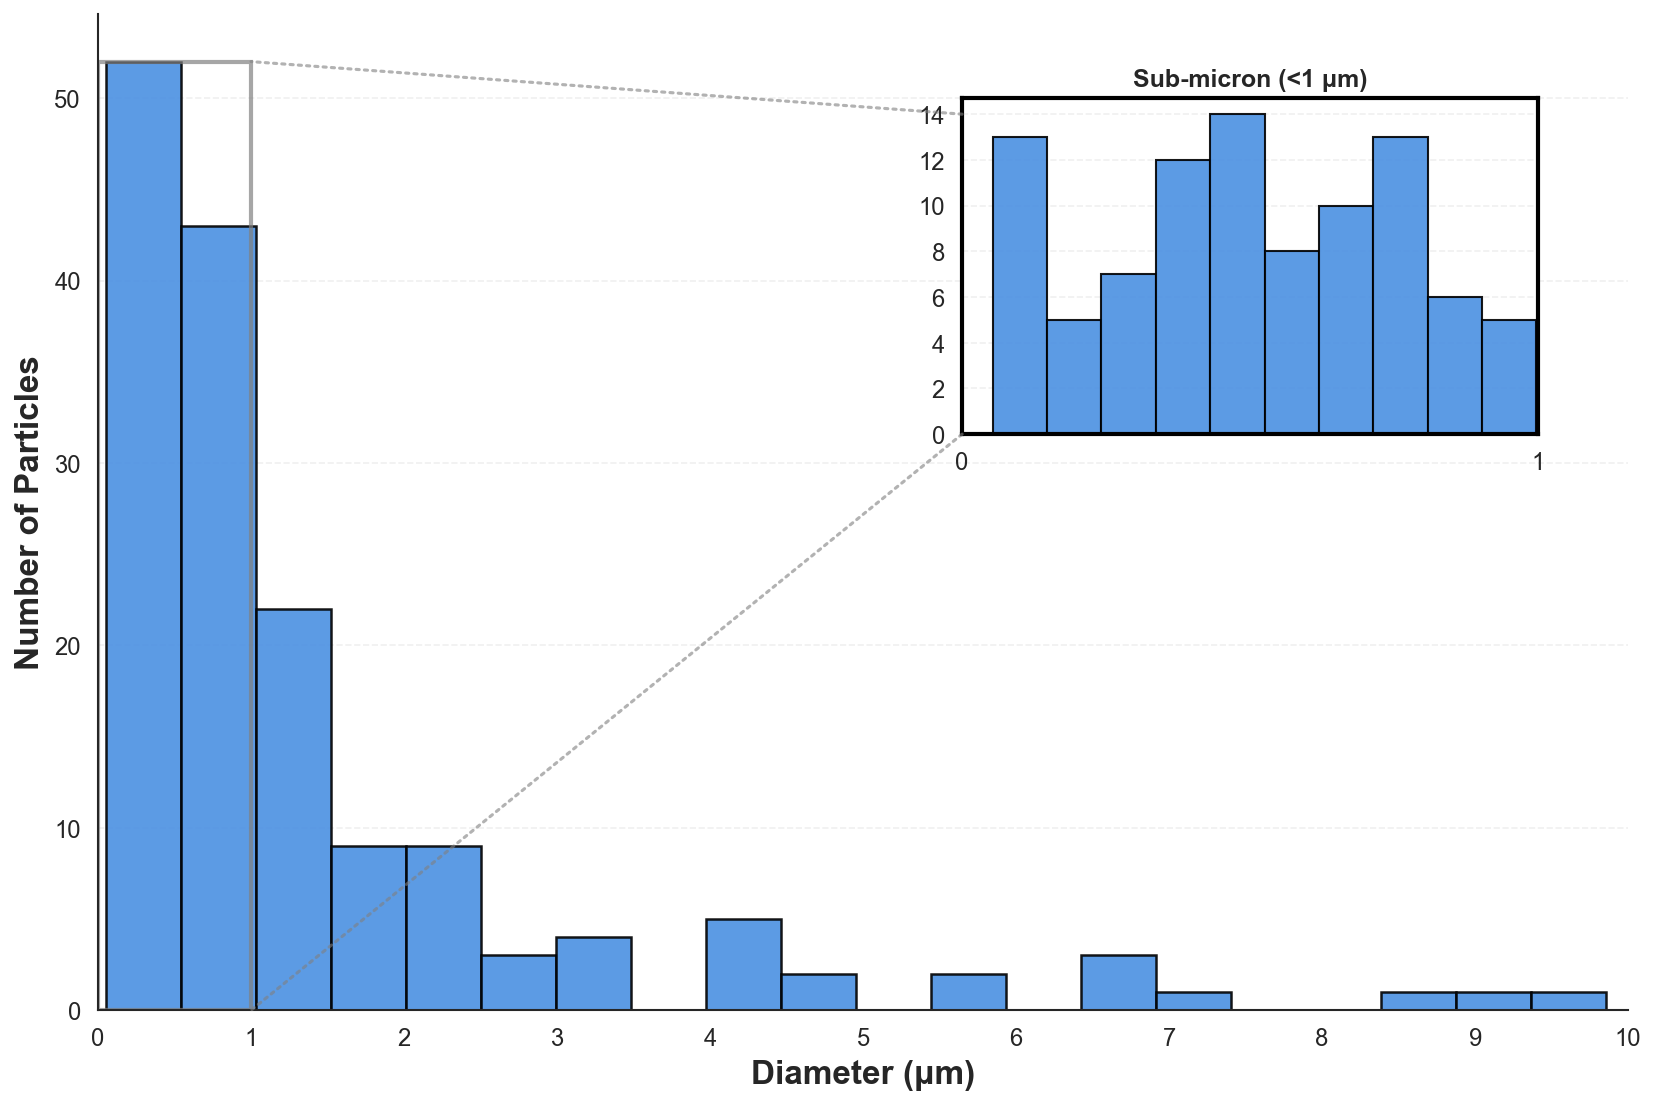


Creating histogram for Dataset F...


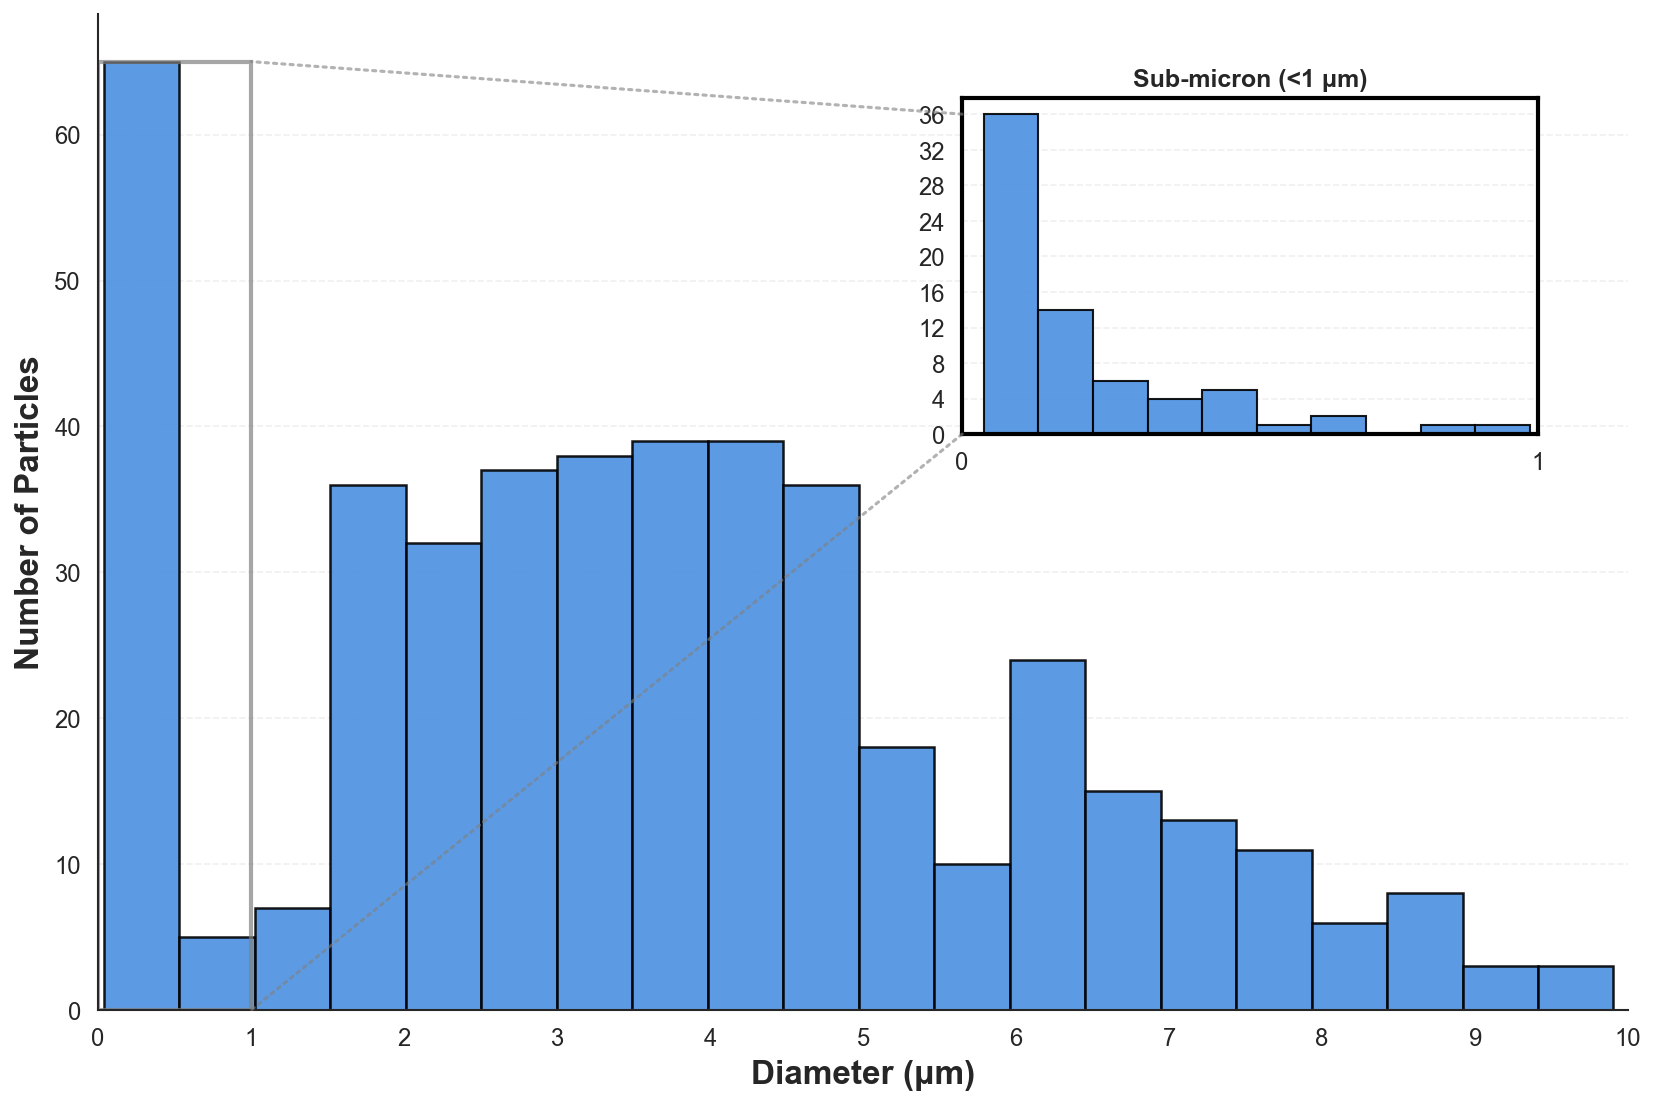


Creating histogram for Dataset G...


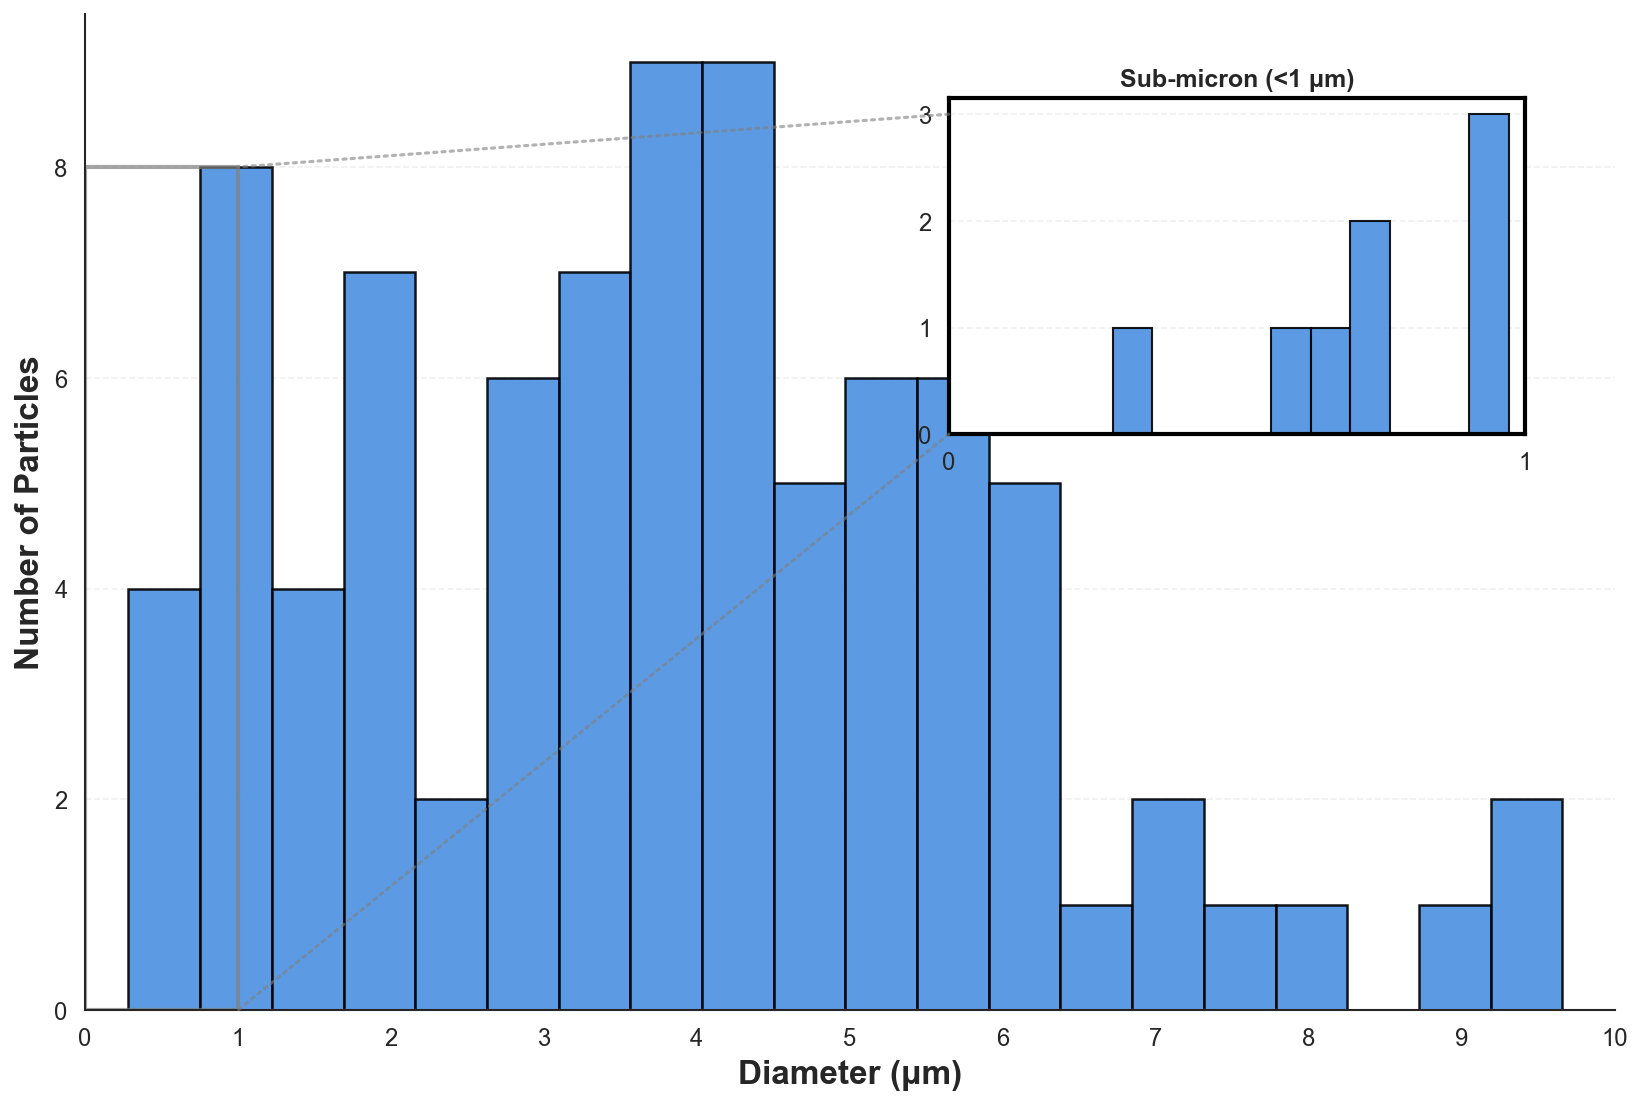


Creating histogram for Dataset H...


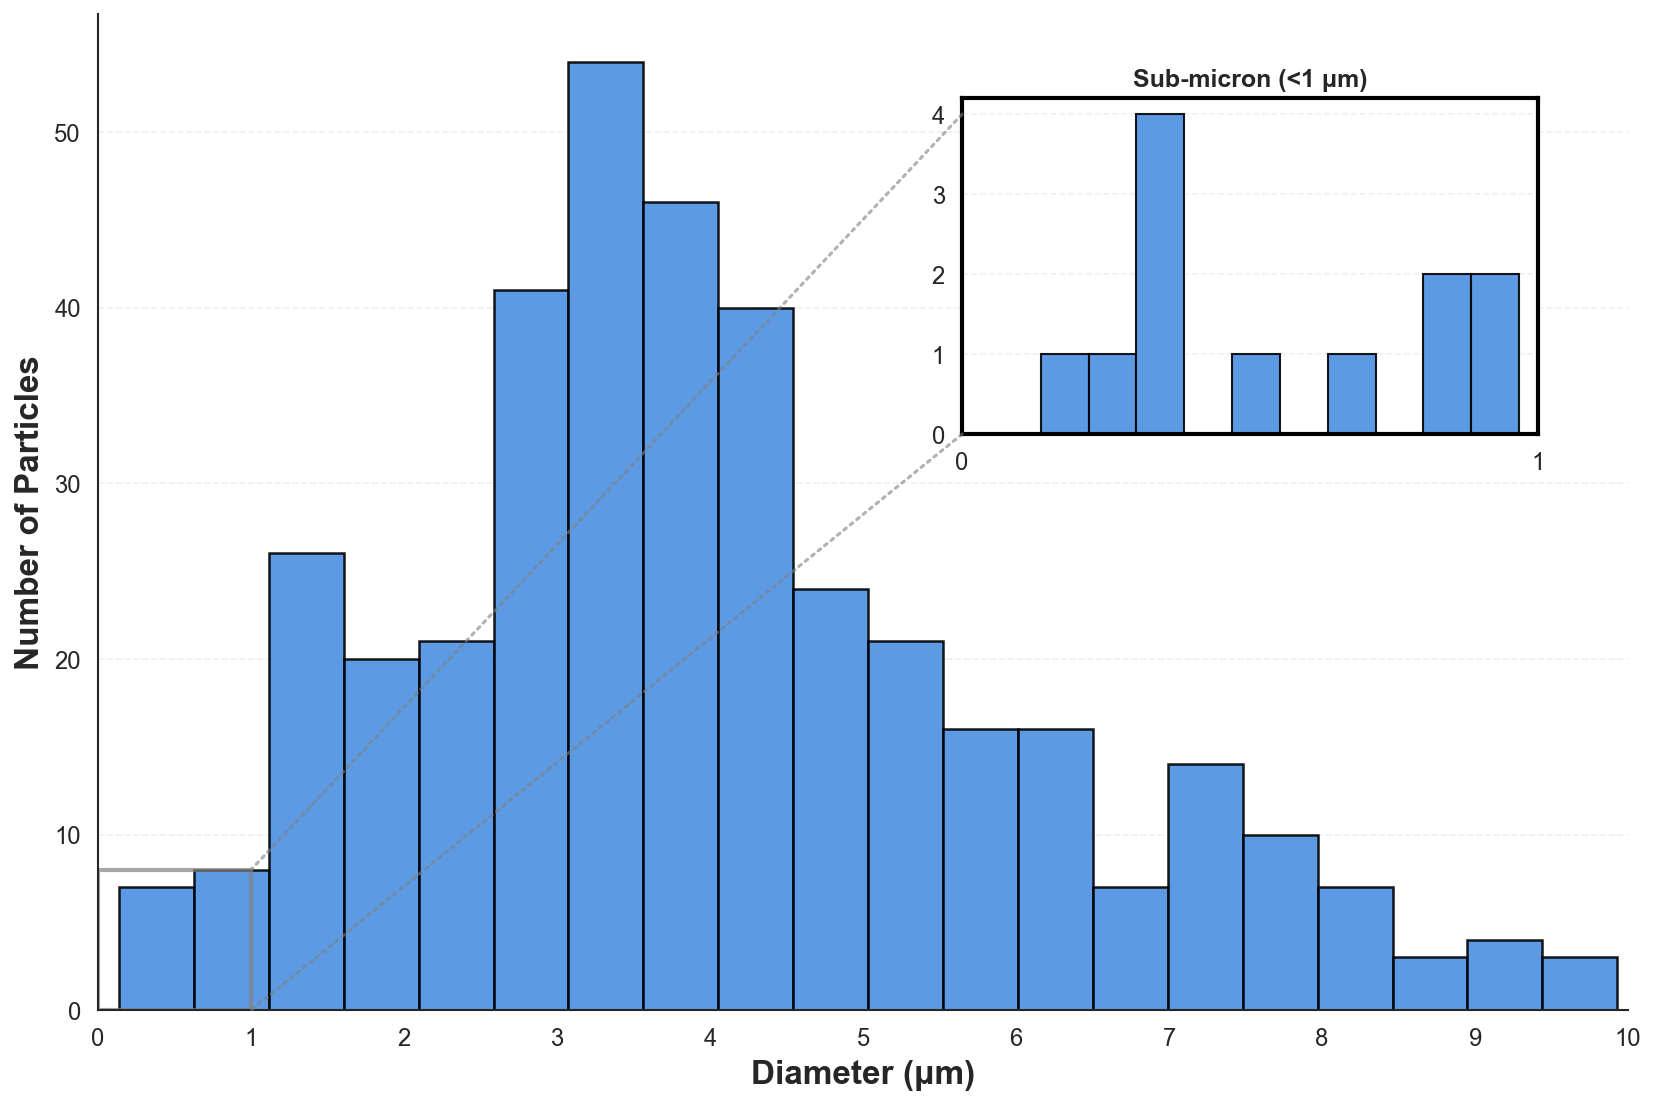


Creating histogram for Dataset I...


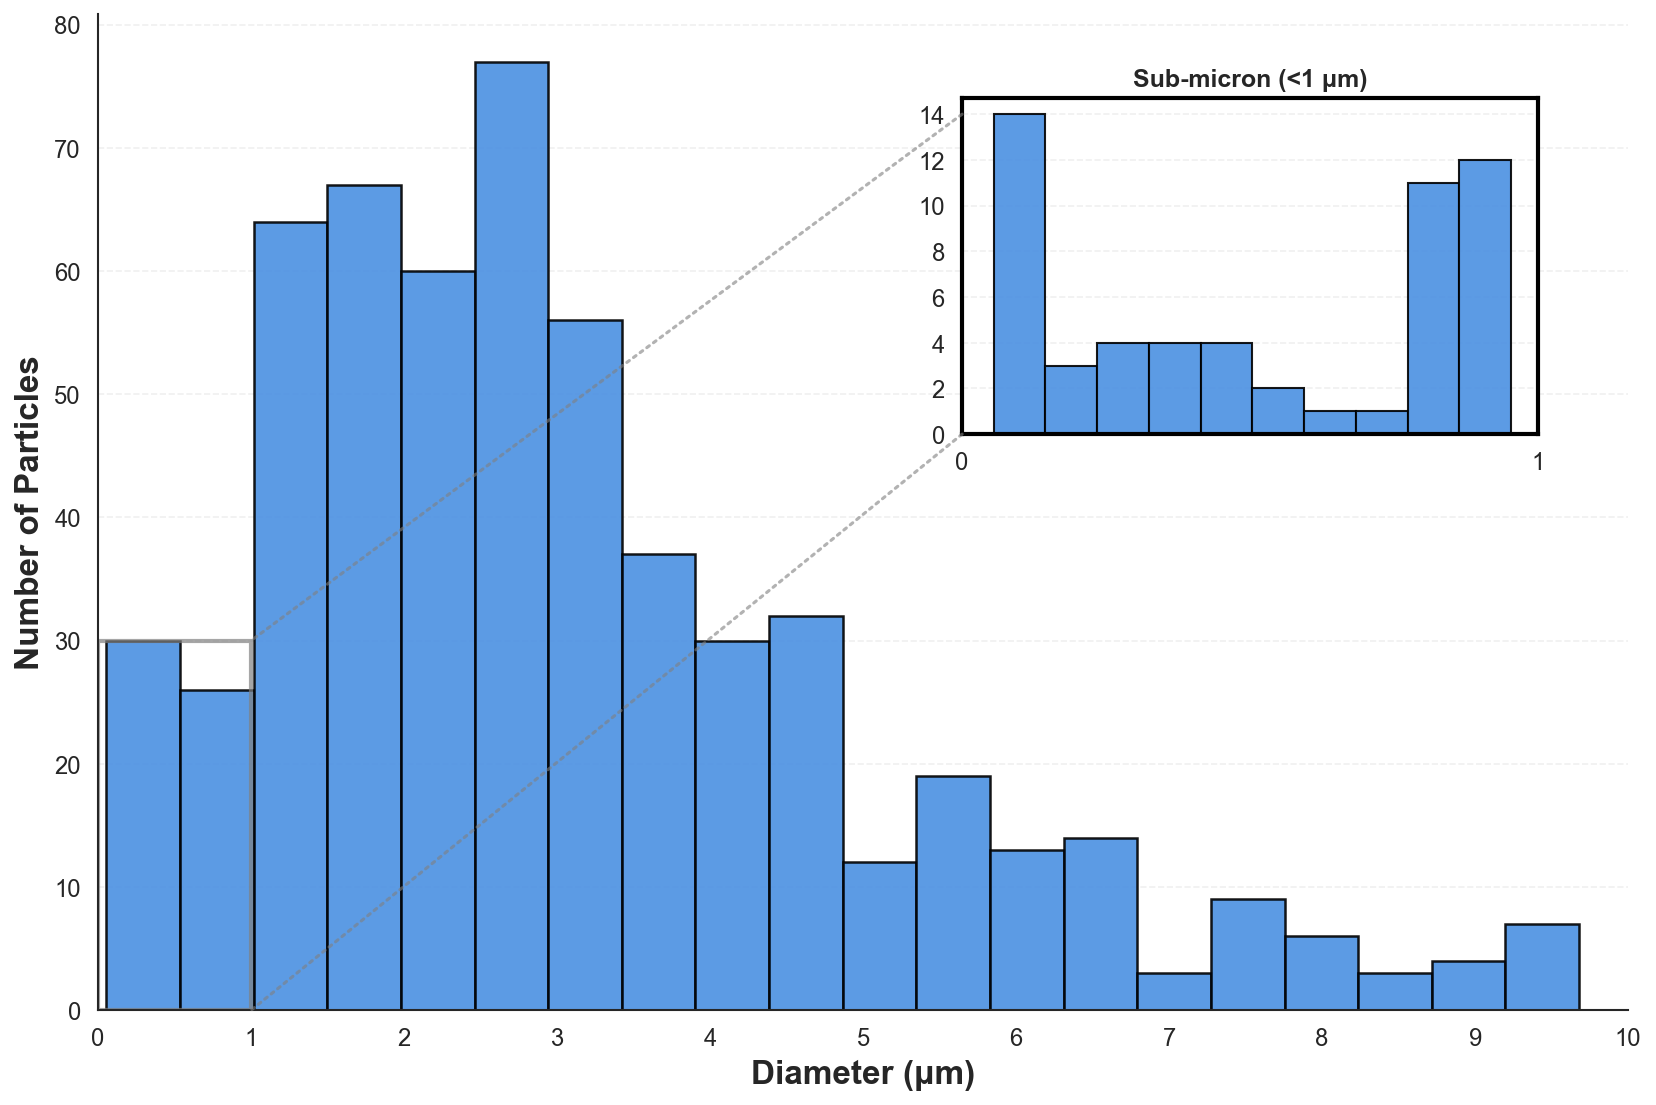


Creating histogram for Dataset J...


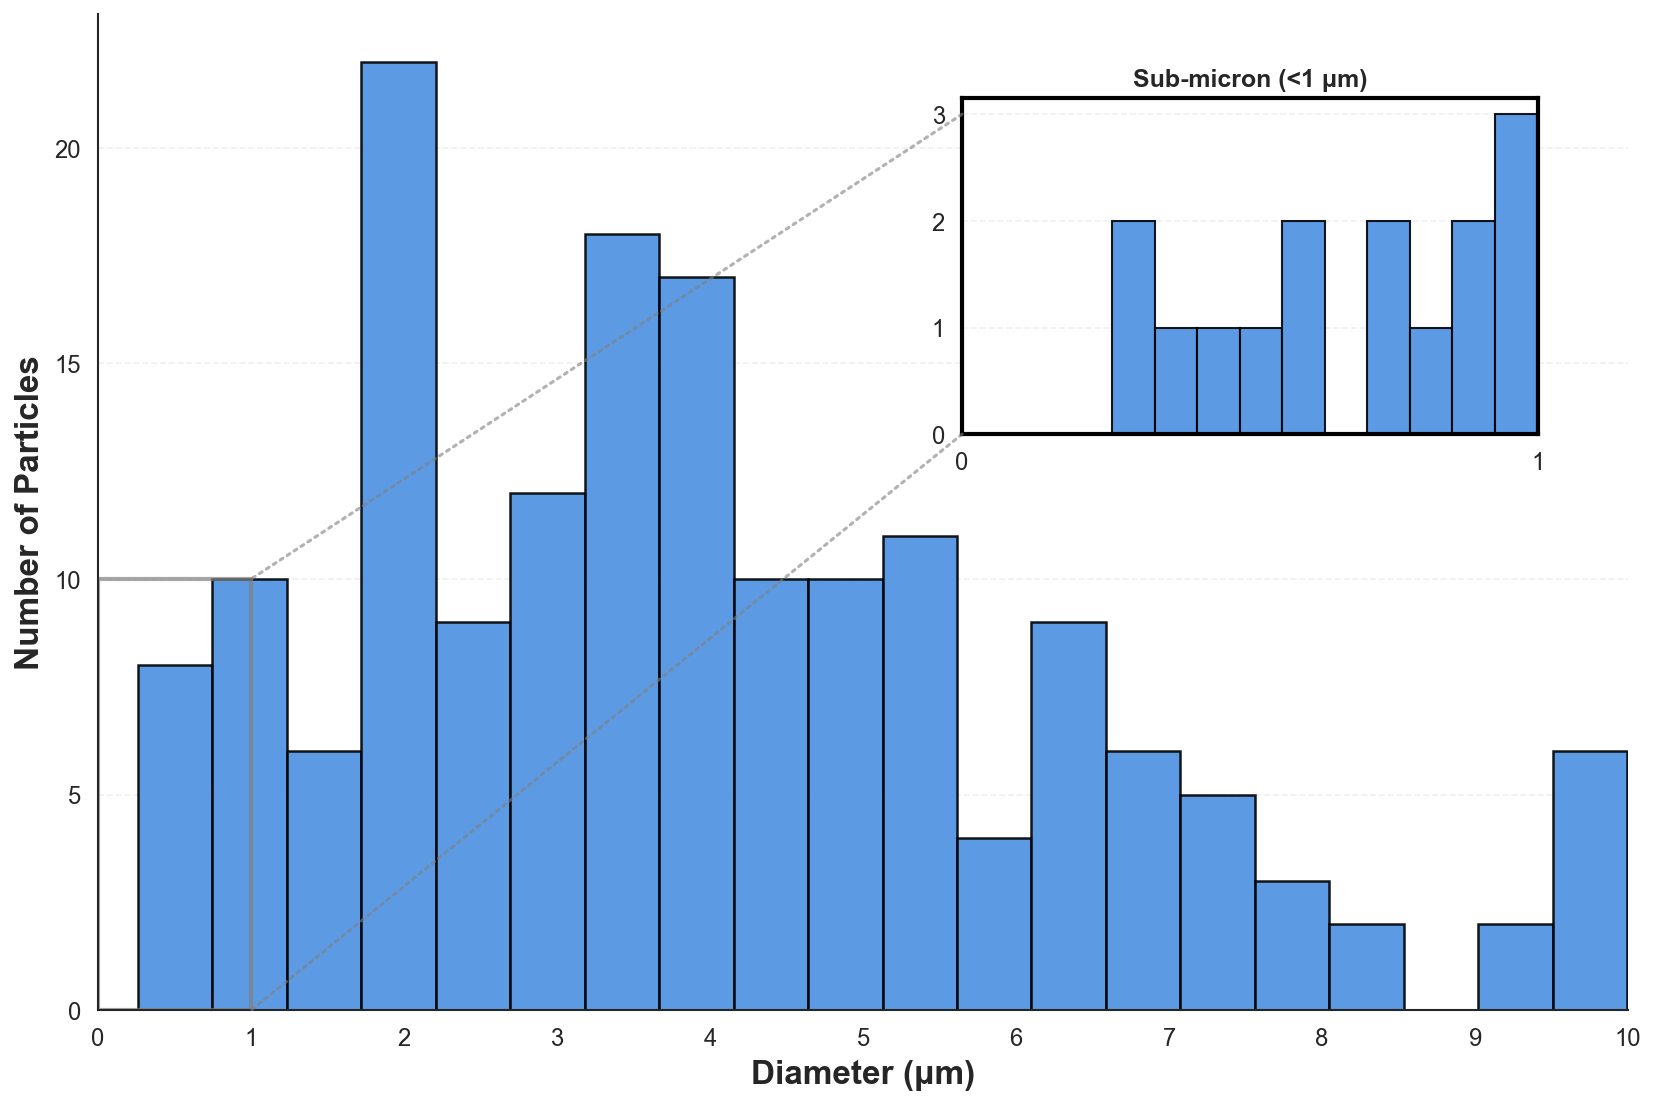


Creating histogram for Dataset K...


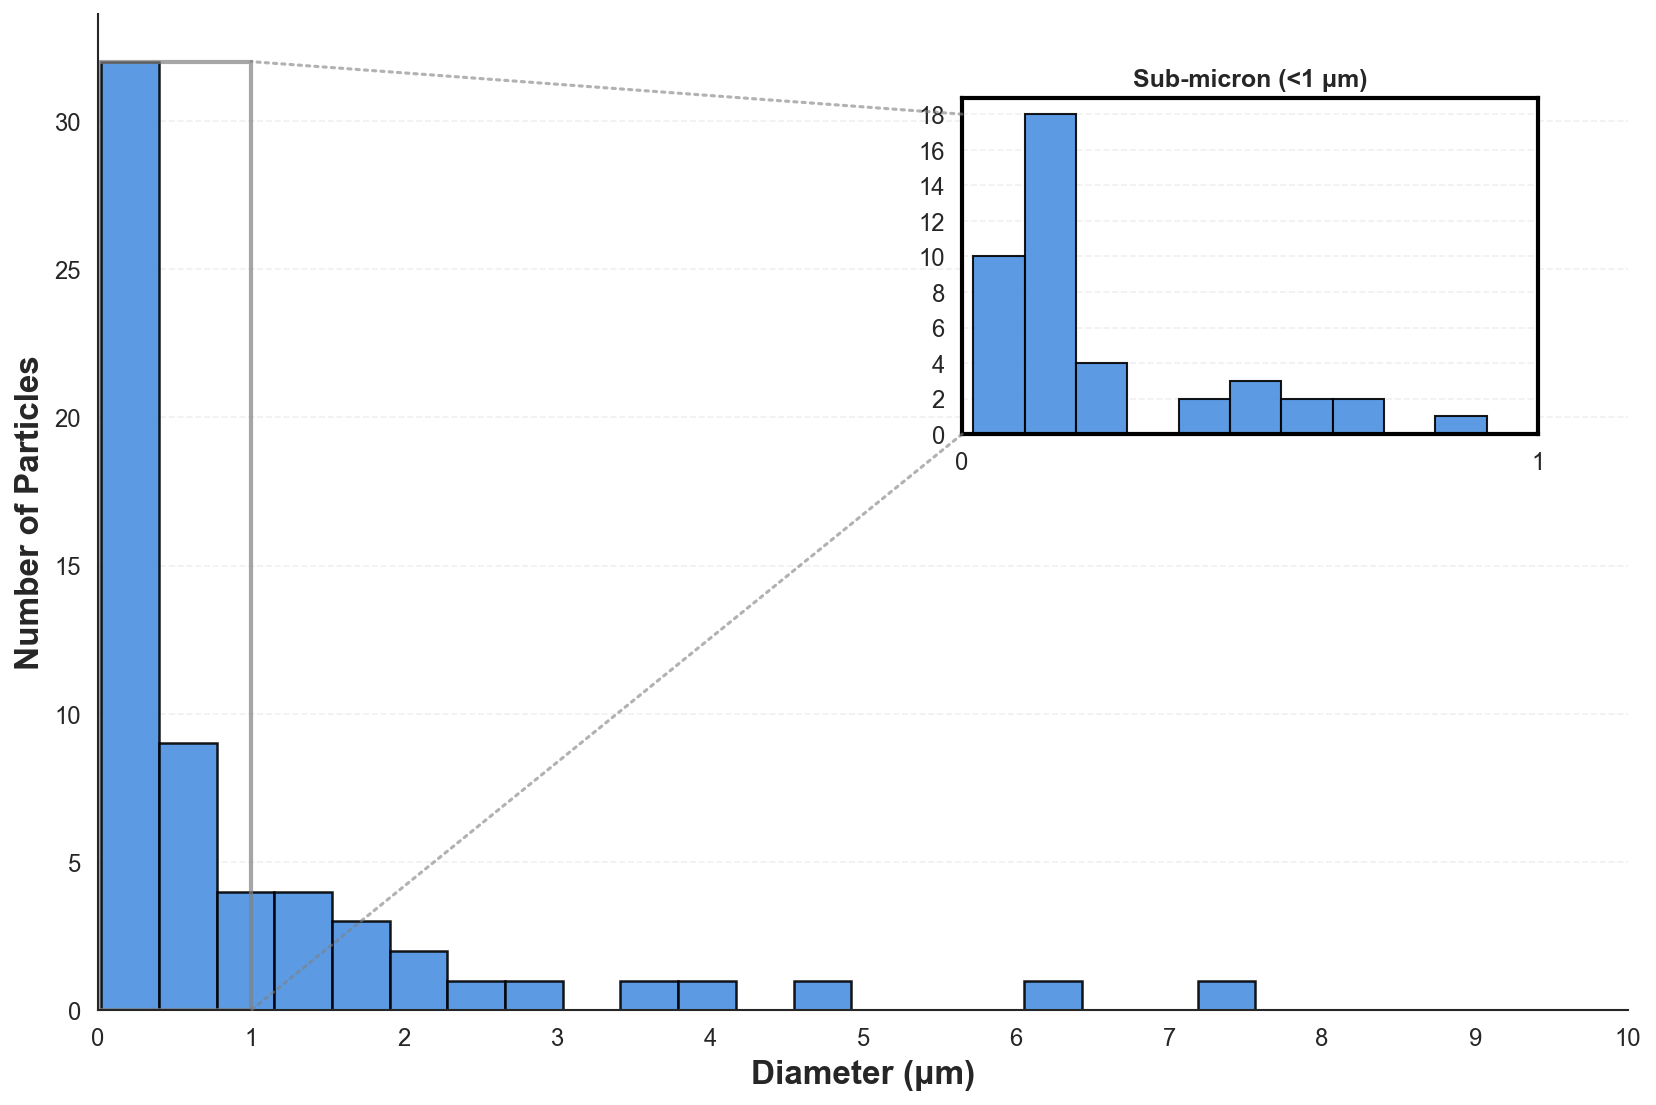


✓ All histograms created successfully


In [54]:
def plot_histogram_with_inset(label, data, max_cutoff_um, submicron_cutoff_um, color):
    """
    Create a histogram with a zoomed-in inset for submicron particles.
    
    Args:
        label: Dataset label
        data: Dictionary with 'diameters' in nm
        max_cutoff_um: Maximum diameter to include (micrometers)
        submicron_cutoff_um: Cutoff for inset zoom (micrometers)
        color: Histogram color
    """
    import matplotlib.ticker as ticker
    from matplotlib.patches import Rectangle
    from matplotlib.ticker import MaxNLocator
    
    # Convert diameters from nm to μm
    diameters_um = data['diameters'] / 1000.0
    
    # Filter by max cutoff
    diameters_filtered = diameters_um[diameters_um <= max_cutoff_um]
    
    # Submicron particles for inset
    submicron = diameters_filtered[diameters_filtered < submicron_cutoff_um]
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    
    # Create main axes with specific position to avoid tight_layout issues
    ax_main = fig.add_axes([0.10, 0.12, 0.85, 0.83])  # [left, bottom, width, height]
    
    # Main histogram - bins=20 as requested
    n, bins, patches = ax_main.hist(diameters_filtered, bins=20, color=color, 
                                      edgecolor='black', linewidth=1.2, alpha=0.9)
    
    ax_main.set_xlabel('Diameter (μm)', fontsize=16, fontweight='bold')
    ax_main.set_ylabel('Number of Particles', fontsize=16, fontweight='bold')
    
    # Set limits to eliminate gaps - explicit range from 0
    ax_main.set_xlim(0, max_cutoff_um)
    ax_main.set_ylim(0, n.max() * 1.05)  # 5% margin at top only
    
    # Set x-axis ticks to show integer values from 0 to max_cutoff
    ax_main.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax_main.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    
    # Add grid
    ax_main.grid(axis='y', alpha=0.3, linestyle='--')
    ax_main.set_axisbelow(True)
    
    # Remove spines for cleaner look
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    
    # Get the maximum height in the submicron region for the box
    submicron_bins_mask = bins[:-1] < submicron_cutoff_um
    if any(submicron_bins_mask):
        submicron_max_height = n[submicron_bins_mask].max()
    else:
        submicron_max_height = 0
    
    # Draw a box around the <1um region in the main histogram
    box = Rectangle((0, 0), submicron_cutoff_um, submicron_max_height,
                    linewidth=2, edgecolor='gray', facecolor='none', 
                    linestyle='-', alpha=0.7)
    ax_main.add_patch(box)
    
    # Create inset axes for submicron particles
    # Position: [left, bottom, width, height] in figure coordinates
    ax_inset = fig.add_axes([0.58, 0.60, 0.32, 0.28])
    
    # Submicron histogram - bins=10 as requested
    if len(submicron) > 0:
        n_sub, bins_sub, patches_sub = ax_inset.hist(submicron, bins=10, color=color,
                                                       edgecolor='black', linewidth=1, alpha=0.9)
        # Remove axis labels as they're redundant
        ax_inset.set_title(f'Sub-micron (<{int(submicron_cutoff_um)} μm)', fontsize=12, fontweight='bold')
        
        # Set limits to eliminate gaps
        ax_inset.set_xlim(0, submicron_cutoff_um)
        ax_inset.set_ylim(0, n_sub.max() * 1.05)
        
        ax_inset.grid(axis='y', alpha=0.3, linestyle='--')
        ax_inset.set_axisbelow(True)
        
        # Format x-axis to show no decimal points (integers only)
        ax_inset.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        ax_inset.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Add border to inset with black outline
        for spine in ax_inset.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
        
        # Draw connection lines from the BOX in main plot to inset (dotted gray lines)
        # Bottom-right corner of box to bottom-left of inset
        con1 = ConnectionPatch(
            xyA=(0, 0), coordsA=ax_inset.transData,
            xyB=(submicron_cutoff_um, 0), coordsB=ax_main.transData,
            color='gray', linestyle=':', linewidth=1.5, alpha=0.6
        )
        fig.add_artist(con1)
        
        # Top-right corner of box to top-left of inset
        con2 = ConnectionPatch(
            xyA=(0, n_sub.max()), coordsA=ax_inset.transData,
            xyB=(submicron_cutoff_um, submicron_max_height), coordsB=ax_main.transData,
            color='gray', linestyle=':', linewidth=1.5, alpha=0.6
        )
        fig.add_artist(con2)
    
    return fig


# Create individual histograms for each dataset
histogram_figures = {}

for label, data in datasets.items():
    print(f"\nCreating histogram for {label}...")
    fig = plot_histogram_with_inset(label, data, MAX_DIAMETER_CUTOFF_UM, 
                                     SUBMICRON_CUTOFF_UM, HISTOGRAM_COLOR)
    histogram_figures[label] = fig
    plt.show()

print("\n✓ All histograms created successfully")

## 7. Probability Density Functions

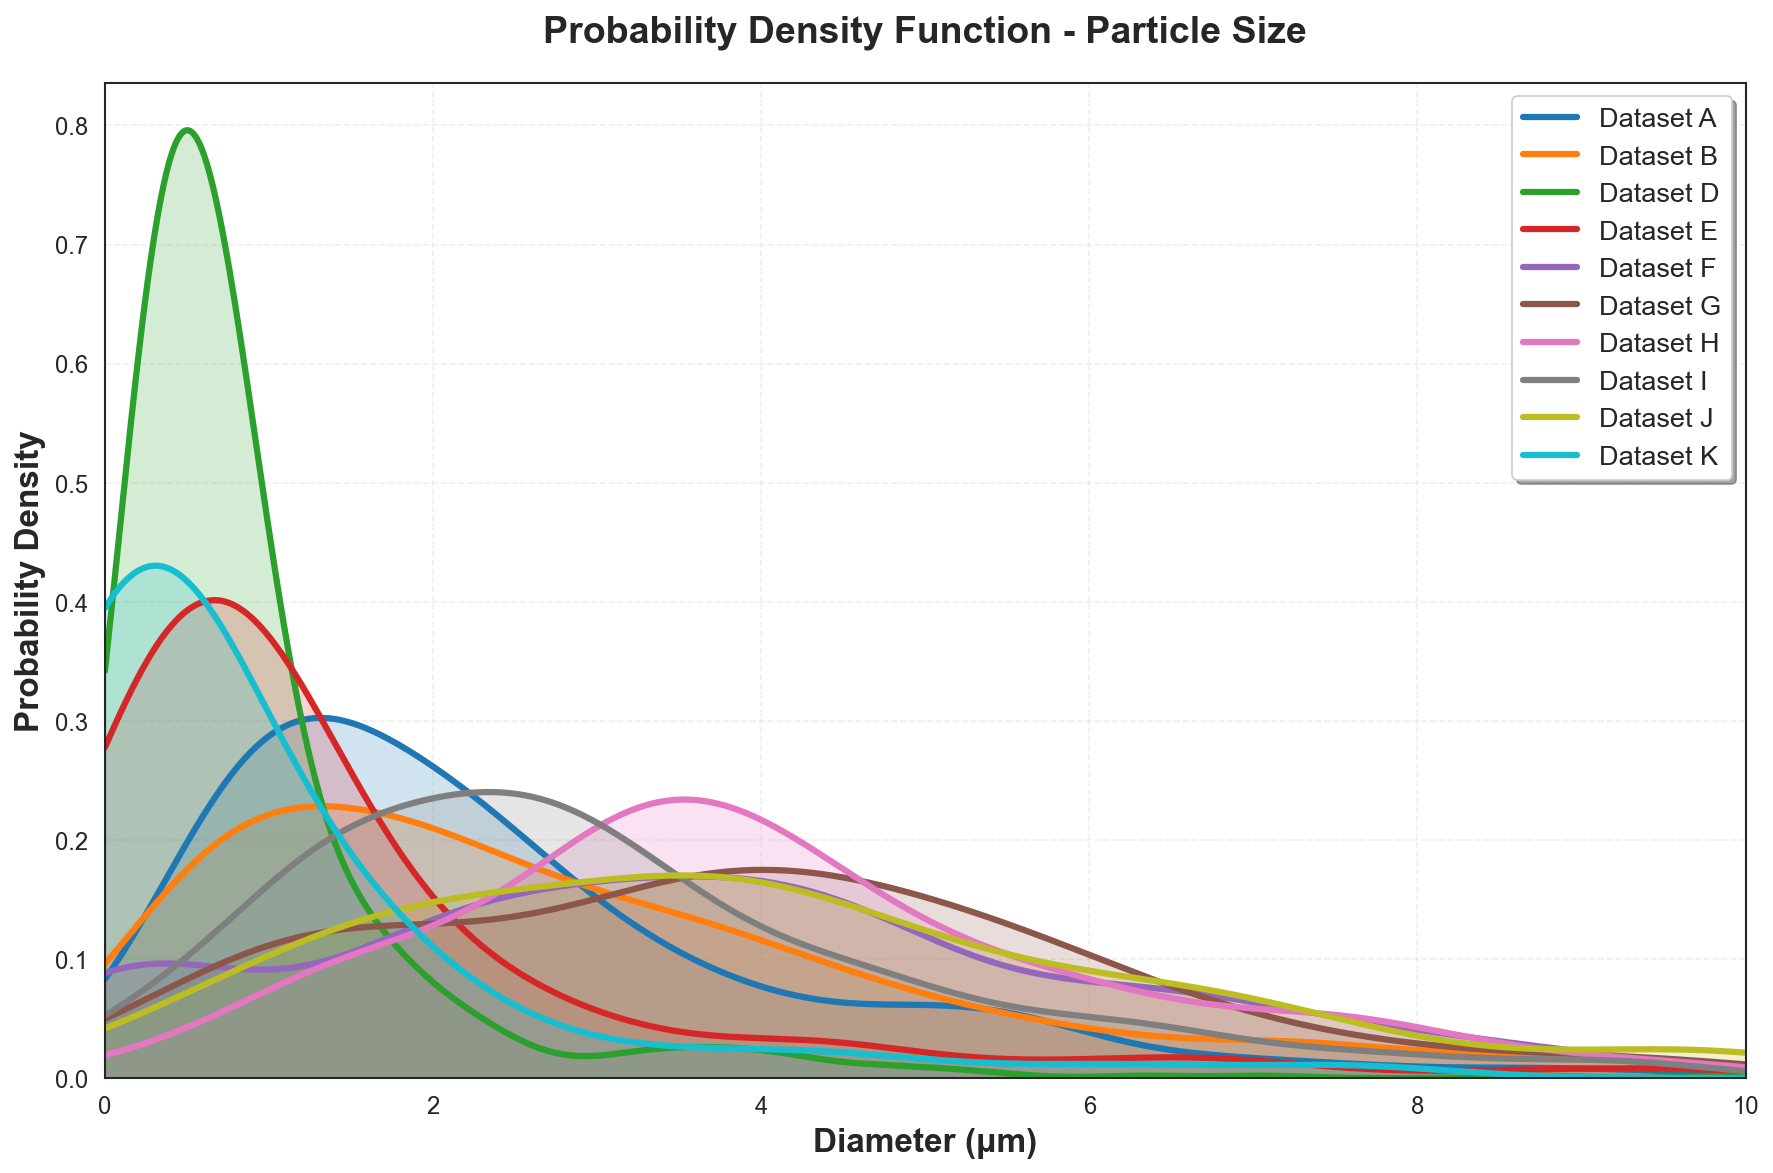

In [55]:
def plot_probability_density(datasets, max_cutoff_um, bandwidth='scott'):
    """
    Create smooth probability density plots using kernel density estimation.
    
    Args:
        datasets: Dictionary of dataset labels to data
        max_cutoff_um: Maximum diameter cutoff (micrometers)
        bandwidth: KDE bandwidth method ('scott', 'silverman', or float)
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Plot KDE for each dataset
    for idx, (label, data) in enumerate(datasets.items()):
        # Convert to μm and filter
        diameters_um = data['diameters'] / 1000.0
        diameters_filtered = diameters_um[diameters_um <= max_cutoff_um]
        
        if len(diameters_filtered) == 0:
            continue
        
        color = colors[idx % len(colors)]
        
        # Kernel Density Estimation
        kde = stats.gaussian_kde(diameters_filtered, bw_method=bandwidth)
        x_range = np.linspace(0, max_cutoff_um, 1000)
        density = kde(x_range)
        
        # Plot KDE curve
        ax.plot(x_range, density, color=color, linewidth=3, label=label)
        ax.fill_between(x_range, density, alpha=0.2, color=color)
    
    ax.set_xlabel('Diameter (μm)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
    ax.set_title('Probability Density Function - Particle Size', fontsize=18, fontweight='bold', pad=20)
    ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=13, loc='best')
    ax.grid(axis='both', alpha=0.3, linestyle='--')
    ax.set_xlim([0, max_cutoff_um])
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    return fig


# Create PDF plot
fig_pdf = plot_probability_density(datasets, MAX_DIAMETER_CUTOFF_UM)
plt.show()

## 8. Cumulative Distribution Functions

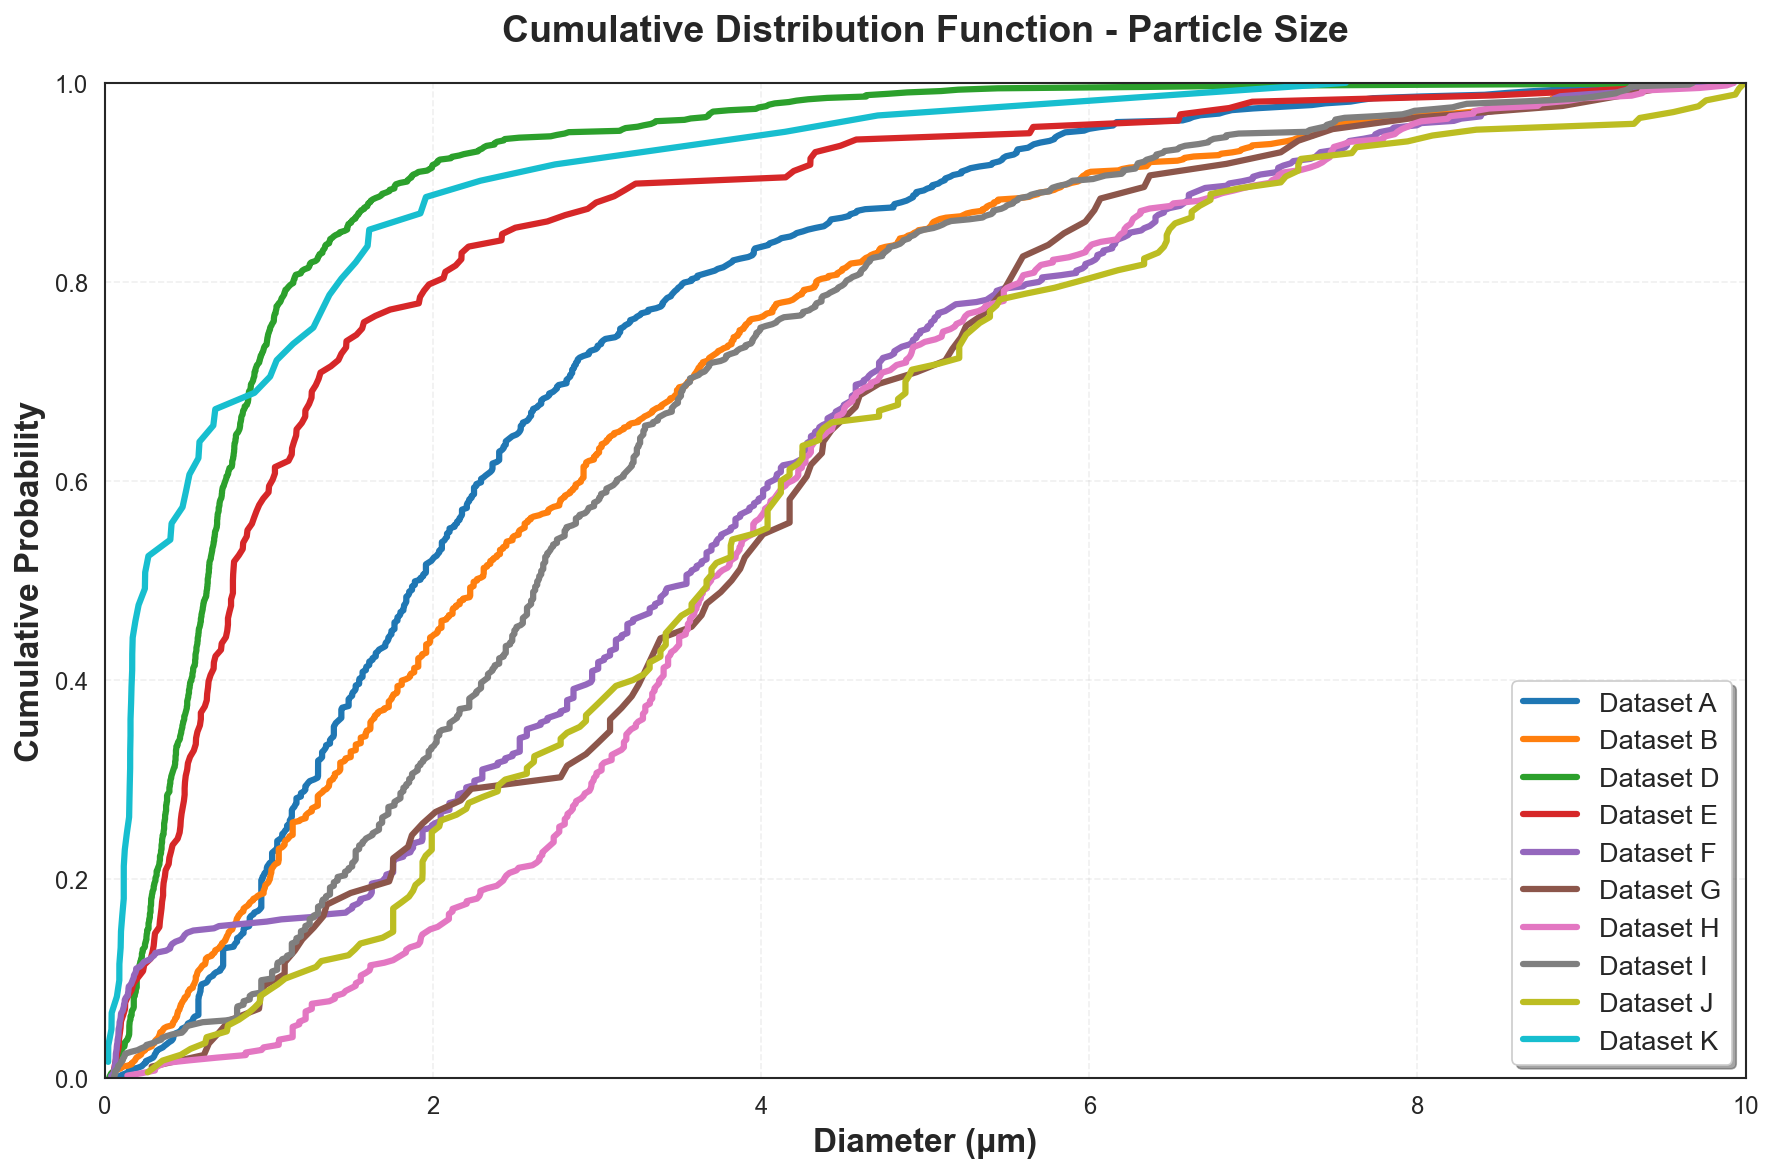

In [56]:
def plot_cumulative_distribution(datasets, max_cutoff_um):
    """
    Create cumulative distribution function plots.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Plot CDF for each dataset
    for idx, (label, data) in enumerate(datasets.items()):
        # Convert to μm and filter
        diameters_um = data['diameters'] / 1000.0
        diameters_filtered = diameters_um[diameters_um <= max_cutoff_um]
        
        if len(diameters_filtered) == 0:
            continue
        
        color = colors[idx % len(colors)]
        
        # Sort values and compute CDF
        sorted_values = np.sort(diameters_filtered)
        cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        
        ax.plot(sorted_values, cdf, color=color, linewidth=3, label=label)
    
    ax.set_xlabel('Diameter (μm)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Cumulative Probability', fontsize=16, fontweight='bold')
    ax.set_title('Cumulative Distribution Function - Particle Size', fontsize=18, fontweight='bold', pad=20)
    ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=13, loc='best')
    ax.grid(axis='both', alpha=0.3, linestyle='--')
    ax.set_xlim([0, max_cutoff_um])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    return fig


# Create CDF plot
fig_cdf = plot_cumulative_distribution(datasets, MAX_DIAMETER_CUTOFF_UM)
plt.show()

## 9. Save All Figures

In [57]:
# Create output folder if it doesn't exist
output_path = Path(OUTPUT_FOLDER)
output_path.mkdir(exist_ok=True)

print("\nSaving figures to", output_path.absolute())
print("="*80)

# Save summary table
fig_summary_table.savefig(output_path / 'summary_statistics_table.png', 
                          dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: summary_statistics_table.png")

# Save individual histograms
for label, fig in histogram_figures.items():
    # Clean label for filename
    clean_label = label.replace(' ', '_').replace('/', '_')
    filename = f'histogram_{clean_label}.png'
    fig.savefig(output_path / filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {filename}")
    
    # Also save as PDF
    pdf_filename = f'histogram_{clean_label}.pdf'
    fig.savefig(output_path / pdf_filename, format='pdf', bbox_inches='tight')
    print(f"✓ Saved: {pdf_filename}")

# Save PDF plot
fig_pdf.savefig(output_path / 'probability_density.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
fig_pdf.savefig(output_path / 'probability_density.pdf', 
                format='pdf', bbox_inches='tight')
print(f"✓ Saved: probability_density.png")
print(f"✓ Saved: probability_density.pdf")

# Save CDF plot
fig_cdf.savefig(output_path / 'cumulative_distribution.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
fig_cdf.savefig(output_path / 'cumulative_distribution.pdf', 
                format='pdf', bbox_inches='tight')
print(f"✓ Saved: cumulative_distribution.png")
print(f"✓ Saved: cumulative_distribution.pdf")

print("="*80)
print("✓ All figures saved successfully!")


Saving figures to /Users/sanjaypradeep/.claude-worktrees/CNT Segmentation/infallible-kowalevski/figures
✓ Saved: summary_statistics_table.png
✓ Saved: histogram_Dataset_A.png
✓ Saved: histogram_Dataset_A.pdf
✓ Saved: histogram_Dataset_B.png
✓ Saved: histogram_Dataset_B.pdf
✓ Saved: histogram_Dataset_D.png
✓ Saved: histogram_Dataset_D.pdf
✓ Saved: histogram_Dataset_E.png
✓ Saved: histogram_Dataset_E.pdf
✓ Saved: histogram_Dataset_F.png
✓ Saved: histogram_Dataset_F.pdf
✓ Saved: histogram_Dataset_G.png
✓ Saved: histogram_Dataset_G.pdf
✓ Saved: histogram_Dataset_H.png
✓ Saved: histogram_Dataset_H.pdf
✓ Saved: histogram_Dataset_I.png
✓ Saved: histogram_Dataset_I.pdf
✓ Saved: histogram_Dataset_J.png
✓ Saved: histogram_Dataset_J.pdf
✓ Saved: histogram_Dataset_K.png
✓ Saved: histogram_Dataset_K.pdf
✓ Saved: probability_density.png
✓ Saved: probability_density.pdf
✓ Saved: cumulative_distribution.png
✓ Saved: cumulative_distribution.pdf
✓ All figures saved successfully!


## 10. Export Summary Statistics to CSV

In [ ]:
# Save summary statistics
summary_csv_path = output_path / 'summary_statistics.csv'
summary_df.to_csv(summary_csv_path)
print(f"\n✓ Summary statistics saved to: {summary_csv_path}")

# Display final summary
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Datasets analyzed: {len(datasets)}")
print(f"Total particles: {sum(d['num_particles'] for d in datasets.values())}")
print(f"Total images: {sum(d['num_images'] for d in datasets.values())}")
print(f"Max diameter cutoff: {MAX_DIAMETER_CUTOFF_UM} μm")
print(f"Submicron cutoff: {SUBMICRON_CUTOFF_UM} μm")
print(f"\nOutput folder: {output_path.absolute()}")
print("="*80)